In [1659]:
import numpy as np
from numpy.linalg import norm
from legacy import legacy_adapter as adapter
from legacy import main as legacy
import template as example
from data import funcs
import regression as reg
from proc_observe import ProcInfo
import gradient_descent as descent

In [1660]:
def lbfgs(func, grad, generations, start, t=0.5, eps=1e-4, max_iter=100):
    dim = len(start)
    point = start
    old_g = grad(point)
    alpha = np.zeros(generations)
    
    s = []
    y = []
    rho = []
    
    z = t * old_g
    for k in range(max_iter):
        point = point - z
        g = grad(point)
        
        delta_x = -z
        delta_y = g - old_g
        tau = delta_y @ delta_x
        old_g = g
        
        if norm(g) < eps:
            break
            
        if tau > eps or k == 0:
            if k >= generations:
                s = s[1:]
                y = y[1:]
                rho = rho[1:]
                
            s.append(delta_x)
            y.append(delta_y)
            rho.append(1. / tau)
        
        q = g
        gens = len(s)
        for it in range(gens):
            i = gens - (it + 1)
            alpha[i] = rho[i] * (s[i] @ q)
            q -= alpha[i] * y[i]
            
        gamma = (s[-1] @ y[-1]) / (y[-1] @ y[-1])
        H = gamma * np.eye(dim)
        z = H @ q
        
        for i in range(gens):
            beta = rho[i] * (y[i] @ z)
            z += s[i] * (alpha[i] - beta)
        
    return point

In [1661]:
def f(point):
    x, y = point[0], point[1]
    return x ** 2 - x * y + y ** 2 + 9 * x - 6 * y + 20

def grad(point):
    x, y = point[0], point[1]
    return np.array([[2 * x - y + 9], [-x + 2 * y - 6]])

In [1662]:
def create_regression_test(func, jacobian, regression, grad):
    def run(x, y, start, t, generations, eps, max_iter):
        r = regression(func, x, y)
        g = grad(x, jacobian, r)
        F = lambda betta: sum(r(betta) ** 2)
        return lbfgs(F, g, generations, start, t, eps, max_iter)
    return run

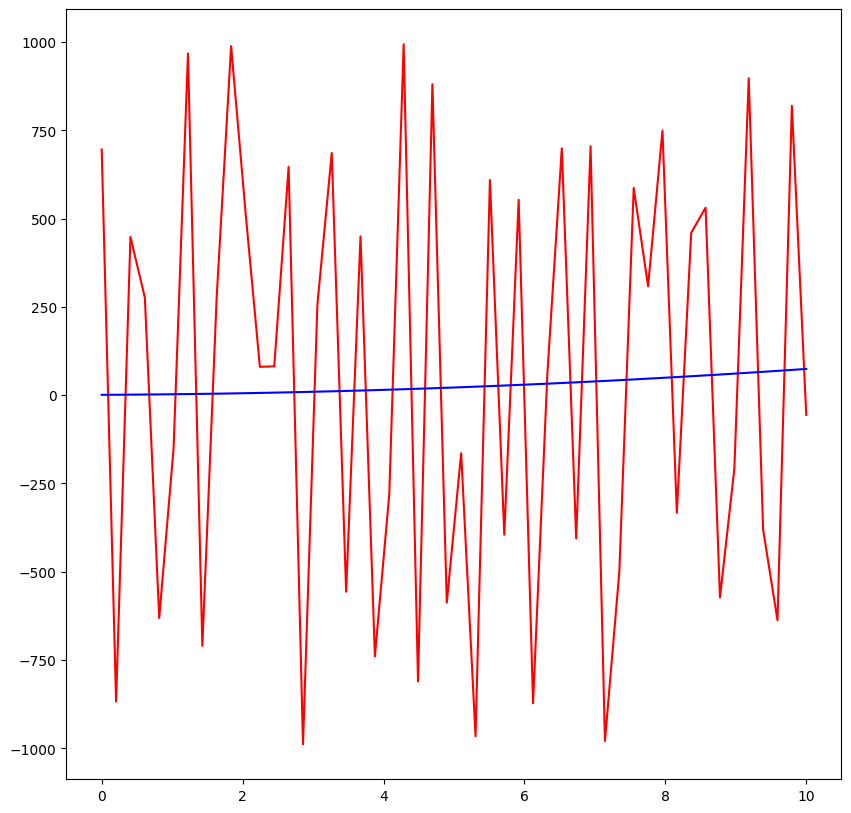

In [1663]:
start = 0
end = 10
steps = 50

test_x, test_y = example.generate_test(lambda x: example.random_function(1000)(x), start, end, steps)
x0 = np.array([1., 1.])
func, jac = funcs["square"]
test = create_regression_test(func, jac, reg.regression, reg.grad)

betta = test(test_x, test_y, x0, 1, 10, 1e-4, 100)

X = np.linspace(start, end, steps)
Y = func(X)(betta)

example.show(test_x, test_y, X, Y)

In [1664]:
betta

array([0.63579907, 0.97321947])